# Real Housewives of New York City Viewership and Title Analysis

In this Jupyter file I import data from Wikipedia on the viewership and cast members of every episode of "The Real Housewives of New York City" (RHONY) by scraping data available on Wikipedia using the requests.get command
I aim to answer 3 questions:

### 1. How do patterns in viewership change across seasons and the cast in an episode?
### 2. How can one predict the viewers of an episode?
### 3. What can be said about the titles of the episodes over time?

Source links are outlined at the end of the document.

An ethical consideration is noted, the data has been sourced from Wikipedia (free to access) and is not sensitive. The Real Housewives of New York City is a television show whose copyright belongs to BRAVO. The data is not used for any malicious purposes and any offensive words in the titles have been censored. There is discussion about the presentation of women through the show, and this is done as ethically as possible, with an upmost respect for women, particularly the women featured on RHONY and their marital status.

## Data Scraping

The first part of my data involves downloading each table containing the list of episodes for every season of RHONY using requests.get. These HTML tables have information on date released, title, U.S. viewers (millions), index, index in season. The pandas library is able to read the HTML tables and covert them to a pandas dataframe. The same technique is used in collecting the second part of my data.

The data is first cleaned by only extracting necessary tables and removing unnecessary duplicated of the "Title" column and offensive words are censorred. A 'Season' column is also added.

In [1]:
#First I need to import the necessary libraries
import requests
import pandas as pd


#This is the first link from which I want to get my data 
RHONY_episodes_link = 'https://en.wikipedia.org/wiki/List_of_The_Real_Housewives_of_New_York_City_episodes'
RHONY_request = requests.get(RHONY_episodes_link)

#Reading in all the tables that are of the correct format (1 per season) and add them to a list
tables = pd.read_html(RHONY_request.text, attrs={'class': 'wikitable plainrowheaders wikiepisodetable'})

#Initialising an empty data frame
rhony_episodes_df = pd.DataFrame()

#Iterating through the list of tables and concatenating them
for table in tables:
    rhony_episodes_df = pd.concat([rhony_episodes_df, table], ignore_index=True)

#Wikipedia has duplicate title's for the Title column, the wrong ones are listed here:
wrong_list = ('Title [137]', 'Title [160]', 'Title [183]','Title [204]', 'Title [230]', 'Title [248]')

#Every epsiode has a title in at exactly one of the title columns so I extract it and put it in the column called "Title"
for index in range(len(rhony_episodes_df)):
    if pd.isna(rhony_episodes_df["Title"][index]):
        for title in wrong_list:
            if not pd.isna(rhony_episodes_df[title][index]):
                real_title = rhony_episodes_df[title][index] 
                rhony_episodes_df.loc[index, "Title"] = real_title
#Then drop all the columns with the wrong title, after extracting their information
for title in wrong_list:
    rhony_episodes_df.drop(title, axis = 1, inplace = True)

#Labelling seasons based when the episode in season value restarts
season_count = int(1)
for index in range(len(rhony_episodes_df)):
    if rhony_episodes_df.loc[index, 'No. in season'] == 1 and index != 0:
        season_count += 1
    rhony_episodes_df.loc[index, 'Season'] = season_count
    
#Removing any digits in square brackets from the viewers column    
rhony_episodes_df['U.S. viewers (millions)'] = rhony_episodes_df['U.S. viewers (millions)'].str.replace(r'\[\d+\]', '', regex=True)

#Censoring any innapropriate language
rhony_episodes_df.loc[73, "Title"] = "S* island"
rhony_episodes_df.loc[139, "Title"] = "Always the B*, Never the Bride"
rhony_episodes_df.loc[94, "Title"] = "S*, Lies and Facials"
rhony_episodes_df.loc[122, "Title"] = "New Beginnings, My A*"


The second part of my dataset involves importing a table which displays the role each cast member had in a given season, it has cast members on one axis, and season on the other. From this data I extrapolate that if a cast member took a full-time role in this season, then they took a full-time role for every episode in that season. Whilst this isn't necessarily true (for example Aviva Drescher was absent for several episodes in season 6 due to health conditions), it is a necessary assumption. Since this data is not readily available, this score is not considered to be whether a cast member was present in an episode, but more so reflecting their role within that season. When Aviva Drescher was absent in episodes in season 6, she was still spoken about by the other cast members, as she was a full-time cast member. Hence this score is to be thought of as an "employment score".

Another generalisation made is the score given to cast members when they take on a "Guest" or "Friend" role. Due to the lack of data, a generalisation is made that a "Friend" contributes about 50% to that of a full-time member and a "Guest" contributes 10%. These scores are arbitrary but based on a viewers' interpretation.

The data is cleaned by removing the outer layer from the table so that 

In [2]:
#The link and request similar to before
rhony_cast_link = 'https://en.wikipedia.org/wiki/The_Real_Housewives_of_New_York_City#Cast'
rhony_cast_table = pd.read_html(rhony_cast_link)

#Extracting the first table from the link
cast_df = rhony_cast_table[1]
#Dropping the outer layer from the table
cast_df.columns = cast_df.columns.droplevel(0)

#Dropping this column (I don't know where it came from)
cast_df = cast_df.drop(columns=['Unnamed: 15_level_1'])

#Giving a binary 1 or 0 score if a cast member is in that season, so that it can be used in a linear model
#I will call this their presence score (if they are present in a season)
for index in range(len(cast_df)):
    for season in range(1, 15):
        season = str(season)
        if cast_df.at[index, season] == "Main":
            cast_df.loc[index, season] = float(1)
            #There are roles below 'full-time' as outlined below
        elif cast_df.at[index, season] == "Friend":
            cast_df.loc[index, season] = 0.5
        elif cast_df.at[index, season] == "Guest":
            cast_df.loc[index, season] = 0.1
        else:
            cast_df.loc[index, str(season)] = 0

#This row acted as a gap between cast members who appeared in a full-time role and those who have not
#This serves no purpose and has been removed
cast_df.drop(index=23, inplace=True)

#Creating a cast list that I can iterate through
cast_list = cast_df['Cast member'].tolist()

#Going through episode and assigning the cast member's presence score for that season to the corresponding episode
#There is further justification/explanation in the read me
for cast_member in cast_list:
    rhony_episodes_df[cast_member] = 0
    member_index = cast_df[cast_df['Cast member'] == cast_member].index[0]
    for episode in range(len(rhony_episodes_df)):
        season = int(rhony_episodes_df.loc[episode, "Season"])
        rhony_episodes_df.loc[episode, cast_member] = cast_df.loc[member_index, str(season)]
        
#Converting dates to date variable        
rhony_episodes_df['Original air date'] = pd.to_datetime(rhony_episodes_df['Original air date'])
#Removing square brackets with numbers inside again
rhony_episodes_df['U.S. viewers (millions)'] = rhony_episodes_df['U.S. viewers (millions)'].str.replace(r'\[.*\]', '', regex=True)
#Here is a preview of my dataset
rhony_episodes_df.head()

,No. overall,No. in season,Title,Original air date,U.S. viewers (millions),Season,Bethenny Frankel,Luann de Lesseps,Alex McCord,Ramona Singer,...,Sai De Silva,Ubah Hassan,Erin Lichy,Jenna Lyons,Jessel Taank,Brynn Whitfield,Jennifer Gilbert,Barbara Kavovit,Elyse Slaine,Bershan Shaw
0,1,1,"""Meet the Wives""",2008-03-04,0.82,1.0,1,1.0,1,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,2,2,"""The Hamptons""",2008-03-11,NaN,1.0,1,1.0,1,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,3,3,"""Fashion Week""",2008-03-18,NaN,1.0,1,1.0,1,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,4,4,"""Social Wife""",2008-03-25,1.14,1.0,1,1.0,1,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,5,5,"""Careful, She Bites""",2008-04-01,NaN,1.0,1,1.0,1,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


This preview of the data shows that the code has worked as desired. There are missing values for the viewers column, and that will be cleaned appropriately (removed) in time. The data is also cleaned by converting the viewers numbers to float.

A CSV file is created with the dataset. It seems that there is a text error in the Reunion episodes with a hyphen that translates oddly to the file. This is remedied in the NLP section where more data cleaining occurs, and words are depunctuated.

## Initial Data Visualisation

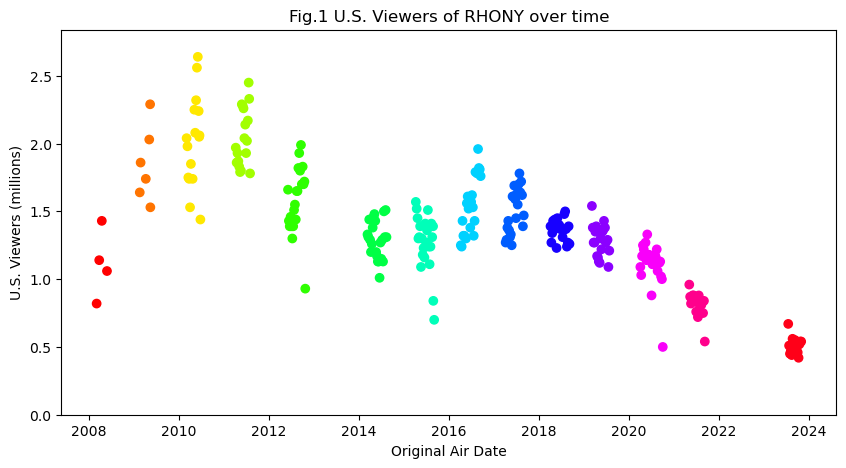

In [3]:
#This cell is for initial data visualisation
#Importing more packages
import matplotlib.pyplot as plt
import numpy as np


rhony_episodes_df.to_csv('rhony_episodes_df.csv', index=False)

#Creating a copy of the original dataset and dropping rows with n/a values for views (not plottable)
rhony_episodes_df_2 = rhony_episodes_df.dropna(subset=['U.S. viewers (millions)']).copy()
#Converting the viewers number to float
rhony_episodes_df_2['U.S. viewers (millions)'] = rhony_episodes_df_2['U.S. viewers (millions)'].astype(float)
total_episodes = len(rhony_episodes_df_2)

#Plotting a scatter graph
plt.figure(figsize=(10, 5))
#Creating a colour map that gives each season a new colour
cmap = plt.get_cmap('hsv', 14)
#Plotting the scatter plot
plt.scatter(rhony_episodes_df_2['Original air date'],rhony_episodes_df_2['U.S. viewers (millions)'], c=rhony_episodes_df_2['Season'], cmap=cmap) 


plt.xlabel('Original Air Date')
plt.ylabel('U.S. Viewers (millions)')
plt.title('Fig.1 U.S. Viewers of RHONY over time')
#Making sure the axis starts at 0, and all data is visualised
plt.ylim(0, max(rhony_episodes_df_2['U.S. viewers (millions)'])+0.2)

plt.show()

A time-series scatterplot was chosen because there are two continuous variables (one being time/date). The seasons are uniquely highlighted. Figure 1 gives initial insight to how the viewership has changed over time. One can see that the peaks are achieved in the third and fourth clusters, corresponding to Season 3 and Season 4. The data initially seems to follow a fourth order polynomial over time (quartic), with peaks in early 2011 and mid 2016, with a trough in mid 2014. The seasons that have the better performing episodes also seem to have a larger spread. These ideas will be explored and validated (or not) statistically.

Season 14 had a delay in being released and featured an entirely new cast, to better reflect the diversity of New York City (as well as a few other reasons). This season could be thought of as an outlier season however it is important to include it, as its cast reflect the changing perception of New York City, and RHONY as a show, a point that is touched on again in this piece of work.

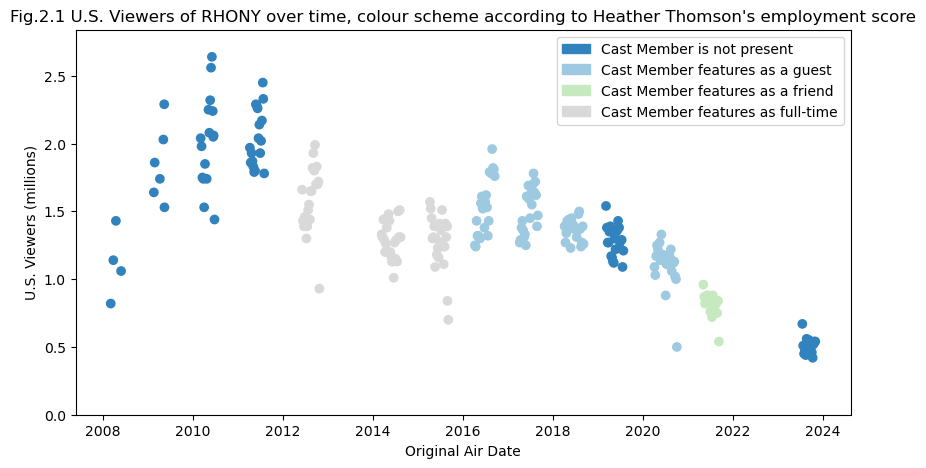

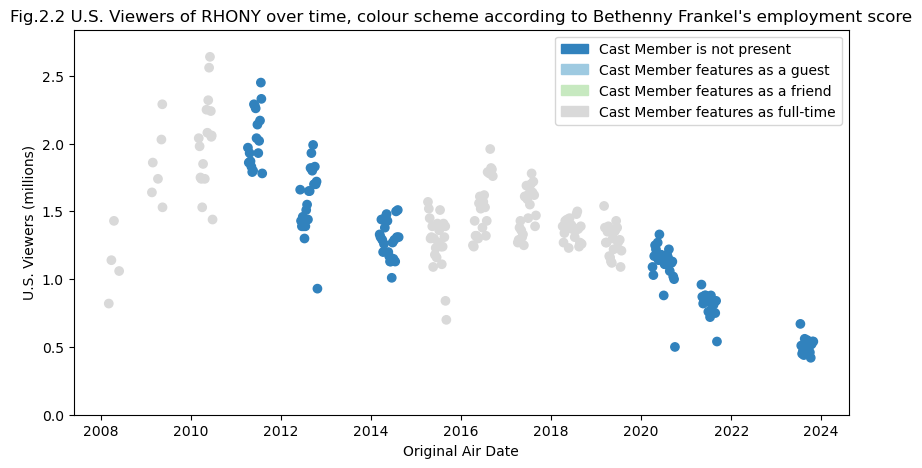

In [4]:
#Plotting a new plot to show how it possible to visualise the same data and display colour based on a certain
#cast member's presence score

#Importing mpatches library to add a legend
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 5))
#A new colour map
cmap = plt.get_cmap('tab20c', 10)
#Choose Heather Thompson as an example as she has been "Full-Time", a "Friend Of", a "Guest" and not employed
plt.scatter(rhony_episodes_df_2['Original air date'],rhony_episodes_df_2['U.S. viewers (millions)'], c=rhony_episodes_df_2['Heather Thomson'], cmap=cmap) 

legend_handles = (mpatches.Patch(color=cmap(0), label='Cast Member is not present'),
                  mpatches.Patch(color=cmap(0.1), label='Cast Member features as a guest'),
                  mpatches.Patch(color=cmap(0.5), label='Cast Member features as a friend'),
                  mpatches.Patch(color=cmap(0.9), label='Cast Member features as full-time'))

plt.legend(handles = legend_handles)
plt.xlabel('Original Air Date')
plt.ylabel('U.S. Viewers (millions)')
plt.title('Fig.2.1 U.S. Viewers of RHONY over time, colour scheme according to Heather Thomson\'s employment score')

plt.ylim(0, max(rhony_episodes_df_2['U.S. viewers (millions)'])+0.2)
plt.show()
#(The scale goes from dark blue to light blue to light green to grey)




#Choose Bethenny Frankel as an example because it seems that Frankel is in the episodes with the most viewers
plt.figure(figsize=(10, 5))
plt.scatter(rhony_episodes_df_2['Original air date'],rhony_episodes_df_2['U.S. viewers (millions)'], c=rhony_episodes_df_2['Bethenny Frankel'], cmap=cmap) 

legend_handles = (mpatches.Patch(color=cmap(0), label='Cast Member is not present'),
                  mpatches.Patch(color=cmap(0.1), label='Cast Member features as a guest'),
                  mpatches.Patch(color=cmap(0.5), label='Cast Member features as a friend'),
                  mpatches.Patch(color=cmap(0.9), label='Cast Member features as full-time'))

plt.legend(handles = legend_handles)
plt.xlabel('Original Air Date')
plt.ylabel('U.S. Viewers (millions)')
plt.title('Fig.2.2 U.S. Viewers of RHONY over time, colour scheme according to Bethenny Frankel\'s employment score')
plt.ylim(0, max(rhony_episodes_df_2['U.S. viewers (millions)'])+0.2)
plt.show()

Figures 2.1 and 2.2 are similar to figure 1. Figure 2.1 shows how Heather Thomson's employment score affects viewership and this is plotted to show how these scores work. Looking at Figure 2.2 Bethenny Frankel's employment score is much easier to visualise, as she was present in seasons 1-3 and 7-11. It seems like Frankel's employment is largely associated with a peak in viewership. How does viewership change for each cast member?

## EDA and Answering Question 1
To answer this, first bar charts are plotted to reflect information about the episodes each cast member is in.

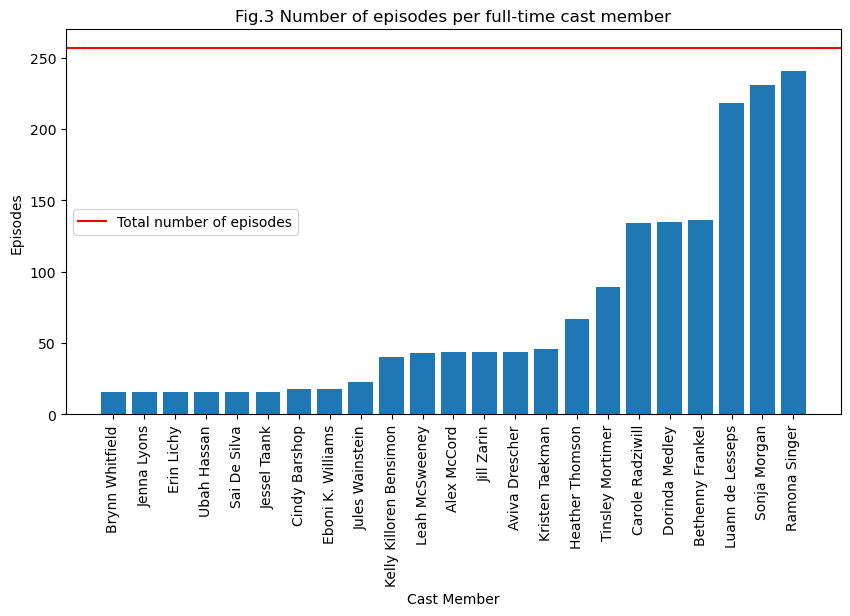

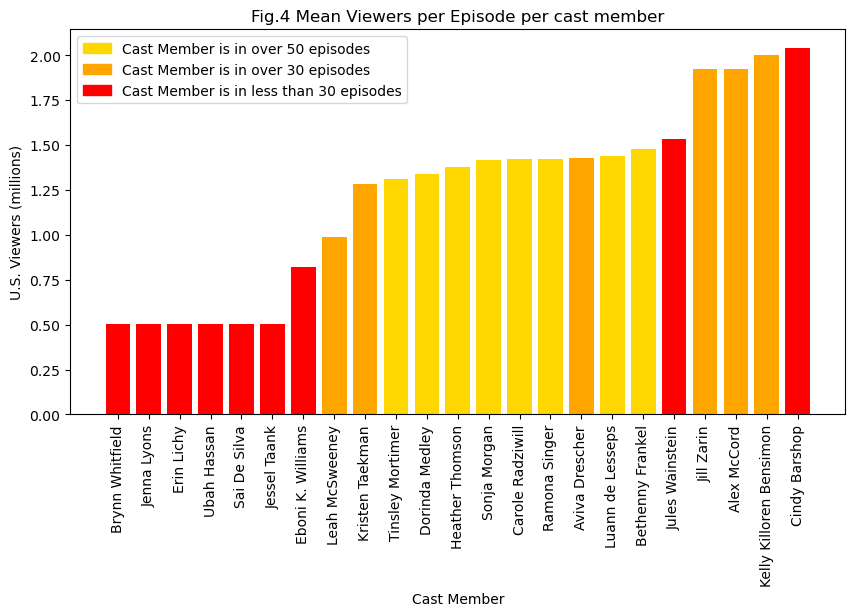

In [5]:
cast_stats = pd.DataFrame(columns = ["Cast member","Episodes","Mean viewers per episode"])
for cast_member in cast_list:
    #Subsetting the main data frame where the cast member is full-time
    cast_member_df = rhony_episodes_df_2[rhony_episodes_df_2[cast_member] == 1].copy()
    episodes = len(cast_member_df)
    #Dropping n/a values
    cast_member_df = cast_member_df.dropna(subset=['U.S. viewers (millions)']).copy()
    cast_stats.loc[len(cast_stats)] = (cast_member,episodes,cast_member_df['U.S. viewers (millions)'].mean())   

#Visualising the number of episodes a cast member is full-time in
cast_stats = cast_stats.dropna(subset=['Mean viewers per episode']).copy()
cast_stats = cast_stats.sort_values(by = 'Episodes')
plt.figure(figsize=(10,5))
plt.bar(cast_stats['Cast member'], cast_stats['Episodes'])
plt.xlabel('Cast Member')
plt.ylabel('Episodes')
plt.xticks(rotation =90)
plt.title("Fig.3 Number of episodes per full-time cast member")
#Adding a column that indicates the total number of episodes
plt.axhline(y = total_episodes, c = "red", label = "Total number of episodes")
plt.legend()
plt.show()

#Visualising them mean number of views for the episodes a cast member is full-time in 
cast_stats = cast_stats.sort_values(by = 'Mean viewers per episode')
plt.figure(figsize=(10,5))

#Creating three categories of cast member based on how many episodes they were in
for index, row in cast_stats.iterrows():
    if row['Episodes'] > 50:
        colour = 'gold'
    elif row['Episodes'] >30:
        colour = "orange"
    else:
        colour = "red"
    plt.bar(row['Cast member'], row['Mean viewers per episode'], color=colour)

#Adding legend handles based on which category each cast member falls in to
legend_handles = (mpatches.Patch(color='gold', label='Cast Member is in over 50 episodes'),
                  mpatches.Patch(color='orange', label='Cast Member is in over 30 episodes'),
                  mpatches.Patch(color='red', label='Cast Member is in less than 30 episodes'))

#Adding the legend
plt.legend(handles = legend_handles)
plt.xlabel('Cast Member')
plt.ylabel('U.S. Viewers (millions)')
plt.xticks(rotation =90)
plt.title("Fig.4 Mean Viewers per Episode per cast member")
plt.show()

Figure 3 is a bar graph depicting the number of episodes each cast member is in (not including episodes with n/a viewers, introducing bias against those who appeared in these episodes). A bar graph was chosen to represent a continuous value associated with each qualitative variable. There is a line for the total number of episodes (without n/a values) which is used to reflect the total proportion of episodes a cast member is in. It is clear to see that Ramona Singer is present in most episodes, this is because she has been in every season until season 14 where the cast was reset and rebooted. The effect of the reboot is also reflected in the emergence of the 6 cast members who each feature in the fewest number of episodes.

Figure 4 shows the mean number of viewers for each episode a cast member is in. It seems that Cindy Barshop has the most viewers per episode. Barshop was only present in one season so the impact of this variable might be misleading, this explains the choice for a colour scale indicating how many episodes each cast member has been. Of the cast members who have been in more than 30 episodes Kelly Killoren Bensimon has the highest viewership per episode, indicating at Killoren Bensimon's popularity (which can be more strongly justified as there is more episode data to support this claim).

The cast members who have been in more than 50 episodes all have a similar mean viewers per episode. These cast members' employment spans such a large proportion of the episodes of the show (especially Singer, De Lesseps and Morgan) so it makes that the episodes they each feature in overlap. Consequentially their mean viewers per episode are similar. Of all the cast members who have featured in more than 50 episodes, Frankel has the highest mean viewers per episode. This statistic supports the prior comment made about how Frankel's presence in seasons perhaps reflects more popular seasons. Frankel being in many epsiodes gives more strength to this claim.

As an extension it could be possible to measure the number of social media followers each cast member has, which could reflect their popularity and contribution to number of viewers.

In the next section box plots are used to explore the distrbution of the data by various catergories.

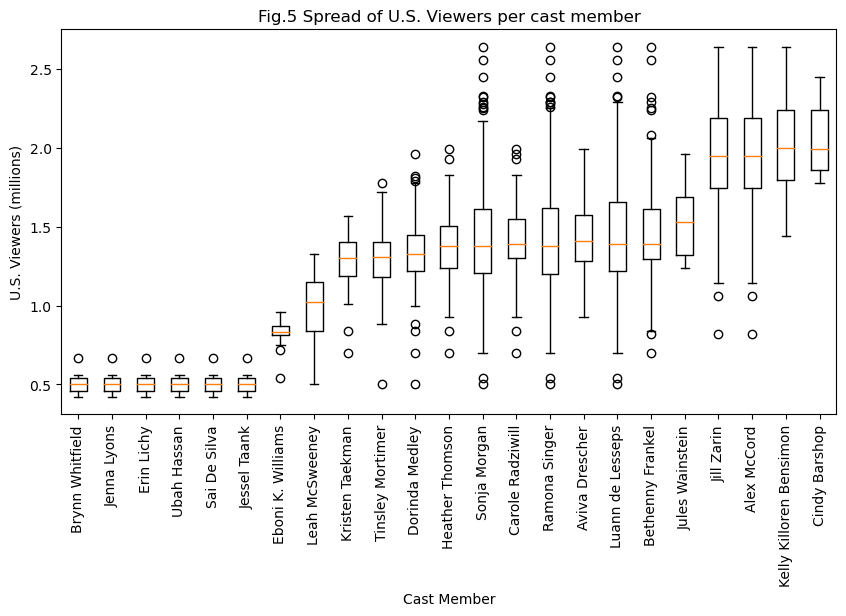

In [6]:
#Putting them in this order is almost abitrary because box plots don't show the mean, however it makes for nicer 
#viewing as they are in some justified order
cast_stats = cast_stats.sort_values(by = 'Mean viewers per episode')

#An empty list to store each set of data for each cast member
cast_members_data = []
#Creating a new cast list without the "guests" and "friends of" (who have no episodes)
cast_list_2 = cast_stats['Cast member'].tolist()

#Appending subsets of the primary dataset
for cast_member in cast_list_2:
    cast_member_data = rhony_episodes_df_2[rhony_episodes_df_2[cast_member] == 1]['U.S. viewers (millions)']
    cast_members_data.append(cast_member_data)

#Plotting a series of box plots
plt.figure(figsize=(10, 5))
plt.boxplot(cast_members_data, labels=cast_list_2)
plt.xlabel('Cast Member')
plt.ylabel('U.S. Viewers (millions)')
plt.xticks(rotation =90)
plt.title('Fig.5 Spread of U.S. Viewers per cast member')
plt.show()

Figure 5 shows the distribution of each cast member's viewership per episode. Box plots were used to demonstrate this because they are a great way to reflect the distribution of a dataset. Boxplots visualise outliers, interquartile range, and median values. This method allows for the visualisation of how the data is spread rather than just using a single statistic for mean number of viewers.

The cast members are put in order of mean, not median, hence it is possible to see how Killoren Bensimon has a greater median viewers per episodes than Barshop, yet Barshop has a greater mean. This might be a result of how Killoren Bensimon is featured in more episodes.

The outliers presented on the graph don't have much significant justification to exclude them. Every episode that Eboni K Williams is in, Leah McSweeney is in too. Williams has 2 episodes that are outliers, yet McSweeney has none, showing that the episodes that are considered outliers for Williams, are not for McSweeney. These outliers are more just reflective of the spread of the data rather than any sense of invalidity.

The cast members who are present in the most episodes (De Lesseps, Singer, and Morgan) have the greatest distribution of viewers per episode, with seemingly the largest number of outliers. This is likely due to the large number of episodes these cast members feature in.

It seems that most of the cast members have little to no skew in their viewers per episode, with Killoren Bensimon having what seems to be a skew value of 0. 

As an extension the skews could be calculated to further reflect how the data is distributed, perhaps even looking at histograms and trying to see if data was drawn from any particular distribution. However, I claim this is beyond the scope of this particular project.

The employment scores are the same for every episode in every season and cast member employment score almost seems to be a confounding variable for the season. Consequentially it makes sense to look at the distribution of episodes by season.

In [7]:
#This cell creates a dataframe that captures and displays the mean and variance of viewers per season
seasons = range(1,15)
season_stats = pd.DataFrame(columns = ["Season","Mean viewers per episode","Variance"])
for season in seasons:
    season_df = rhony_episodes_df_2[rhony_episodes_df_2["Season"] == season].copy()
    season_df = season_df.dropna(subset=['U.S. viewers (millions)']).copy()
    mean_views = round(season_df['U.S. viewers (millions)'].mean(),3)
    variance_views = round(season_df['U.S. viewers (millions)'].var(),3)
    season_stats.loc[season] = (season,mean_views,variance_views)  
    print(f"Season ", season, " had a mean of ", mean_views, " million U.S. viewers per episode with a variance of ", variance_views)

Season  1  had a mean of  1.112  million U.S. viewers per episode with a variance of  0.063
Season  2  had a mean of  1.848  million U.S. viewers per episode with a variance of  0.077
Season  3  had a mean of  2.017  million U.S. viewers per episode with a variance of  0.114
Season  4  had a mean of  2.041  million U.S. viewers per episode with a variance of  0.045
Season  5  had a mean of  1.583  million U.S. viewers per episode with a variance of  0.06
Season  6  had a mean of  1.291  million U.S. viewers per episode with a variance of  0.019
Season  7  had a mean of  1.273  million U.S. viewers per episode with a variance of  0.042
Season  8  had a mean of  1.532  million U.S. viewers per episode with a variance of  0.045
Season  9  had a mean of  1.503  million U.S. viewers per episode with a variance of  0.027
Season  10  had a mean of  1.366  million U.S. viewers per episode with a variance of  0.006
Season  11  had a mean of  1.284  million U.S. viewers per episode with a varian

This initially looks like a seasons' mean number of viewers is correlated with its variance. To further test this claim, the boxplots of viewers are plotted for every season.

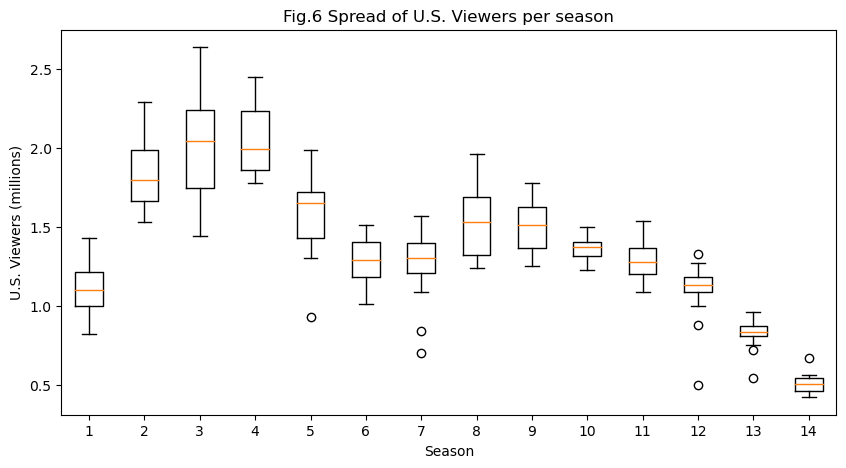

In [8]:
#This cell explores the spread of number of viewers by season, similar to previously with cast members
seasons = range(1,15)
seasons_data = []
for season in seasons:
    season_data = rhony_episodes_df_2[rhony_episodes_df_2["Season"] == season]['U.S. viewers (millions)']
    seasons_data.append(season_data)

#Plotting
plt.figure(figsize=(10, 5))
plt.boxplot(seasons_data, labels=seasons)
plt.xlabel('Season')
plt.ylabel('U.S. Viewers (millions)')
plt.title('Fig.6 Spread of U.S. Viewers per season')
plt.show()


Figure 6 shows the distribution of the viewership by season by plotting a series of box plots (with similar justification as the choice of graph for figure 5).

It should be noted that Season 1 has 3 data points due to missing data so perhaps this box plot should not be largely considered.

This figure supports the previous claim that the number of viewers seems to be polynomially quartic over time (by the shape of the data). This also supports the claim that Seasons 3 and 4 performed best due to them both having the highest medians, however the tail of the box plot of Season 3 indicated some of its less viewed episodes were outperformed by the most viewed episodes in other seasons.

There are again outlier variables however they are unique to each season so the justification for keeping them isn't the same as in figure 5 (where the same episodes were outliers in one box plot but not another). The outliers do again reflect the spread of the data and won't be considered invalid. The strongest outlier seems to be in Season 12, and upon inspection this episode was the "Secrets Revealed" episode. This is a unique format of episode that sometimes is featured at the end of a season, revealing information that has been discovered since the end of filming for that season. One of the outliers in Season 7 has the same style of episode. These episodes are definitely unique and could be justified as outliers that deserves removing however they do reflect the nature of the dataset. As unique episode structures reflect the uniqueness of the dataset it is justified to keep these episodes in.

This figure supports the prior claim that the episodes with more views have a greater spread of data for example Season 3, which has a large median and large interquartile range, and Seasons 13 and 14 which have low medians and low interquartile ranges.


Whether or not the number of viewers of episodes in a season and the spread of the episodes in a season are correlated can be put to a hypothesis test.

First it is important to outline the choice of summary statistics for the season used to reflect the spread and the number of viewers. The choice for mean and variance are justified over median and interquartile range, as they consider all the data. Whilst there are skew and outliers in the data, these are important in reflecting the data. Pearson's correlation co-efficient ($\rho$) can be used to measure the correlation between these two variables for each season.

$H_0:$ constructed as there being no correlation between the mean viewers per episode in a season, and the variance of viewers of episodes in a season (i.e. $\rho = 0$)

$H_1:$ constructed as there being positive correlation between the two variables (i.e. $\rho > 0$)


In [9]:
from scipy import stats
mean_var_corraltion, p_value = stats.pearsonr(season_stats["Mean viewers per episode"],season_stats["Variance"])
print(f"The pearson correlation between the mean and variance is: ", round(mean_var_corraltion,3),"\nand the p value, for a hypothesis test is: ", round(p_value,4))

The pearson correlation between the mean and variance is:  0.702 
and the p value, for a hypothesis test is:  0.0051


This hypothesis test gives a p value of 0.0051, which is incredibly small (lower than a standard value of 0.05) hence it is possible to determine that there is strong positive correlation between the mean number of viewers per episode in a given season and the variance of the number of viewers per episode that given season.

## Answering Question 2

The next section aims to answer question 2. A linear model is used to predict the number of viewers for an episode, based on the casts' employment scores for that episode and the date it was released, and a function applied to the date it was released. The reason a linear model was chosen is due to its interpretability. A linear model also allows for the calculation of coefficients in the model that, for the cast member variables, reflect how much each cast member contributes to the viewership per episode. It is also possible to explore the claim that the viewership is distributed according to a quartic polynomial in time. Further explanation is given of these facets is given in the appropriate section.

One of the requirements for a linear model is that the data points (episodes) are independent. While this might not necessarily be the case, it will be assumed to be true.

Another requirement is that the data is normally distributed with constant variance, as the box plots have shown the data does seem to be unskewed (hence a normal distribution is a fair assumption). Constant variance may be a condition that is harder to assume as true, as it seems that there is correlation between a seasons viewership and its variance, however, it will be assumed to be true.

The date variable is processed to be more interpretable in the model. First the days since the premiere episode is calculated so that a float object can be passed through the linear model. This value is standardised so it is on the same scale as other variables, but also for when this value is raised to the power of 4, so that values are not excessively large.

A note about the input variables for the linear model. Each member of the reboot cast will have linearly identical columns, hence they are merged and treated as one entity. Eboni K. Williams and Bershan Shaw have the same collinearity issue, so they are merged too. Due to the number of variables in model 1 it is possible to encounter collinearity between columns. The model is refined to model 2 with fewer variables. As an extension PCA could be used for model selection, to see what proportion of the variance each variable accounts for.

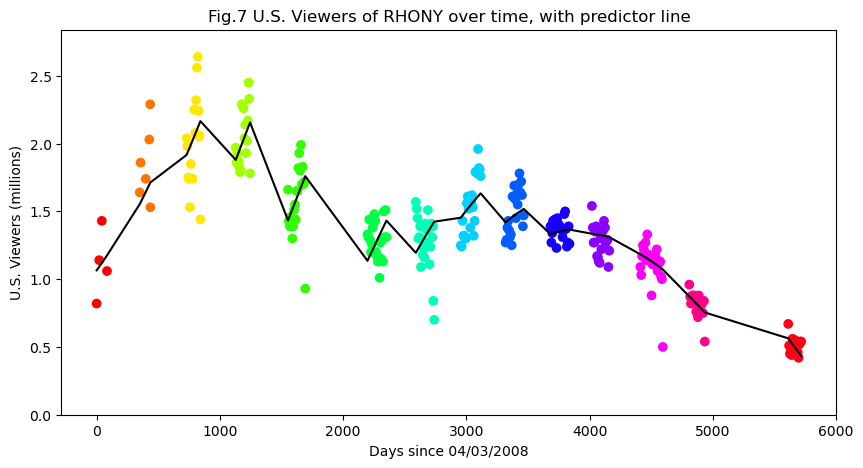

In [10]:
#Importing a linear regression model package and a test-train split function
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

rhony_episodes_lm_df = rhony_episodes_df_2.copy()
#Converting the dates into "days since premiere" because linear models aren't equipped to handle date/time objects
start_date = min(rhony_episodes_lm_df['Original air date'])
rhony_episodes_lm_df['Original air date'] = (rhony_episodes_lm_df['Original air date'] - start_date).dt.days
rhony_episodes_lm_df.rename(columns={'Original air date': 'Days since premiere'}, inplace=True)
rhony_episodes_lm_df['Days since premiere'].astype(float)

#These are the names of the columns to extract to use as response variables
#Using the cast and the days since premiere to predict viewers
X_col_titles = cast_list.copy()
X_col_titles.extend(['Days since premiere'])

#Standardising the days since premiere variable to be between 0 and 1
X_cols = rhony_episodes_lm_df[X_col_titles].copy()
X_cols['Days since premiere'] = X_cols['Days since premiere']/X_cols['Days since premiere'].max()
#This variable is no longer a measure of days, but a measure of recentness
X_cols.rename(columns={'Days since premiere': 'Recentness'}, inplace=True)

#Creating columns that are powers of the recentness
X_cols['Recentness^2'] = np.power(X_cols['Recentness'], 2)
X_cols['Recentness^3'] = np.power(X_cols['Recentness'], 3)
X_cols['Recentness^4'] = np.power(X_cols['Recentness'], 4)

#The columns associated with the reboot cast will all be linearly dependent so I delete all but one
#and associate it to the 6 of them
X_cols.drop(X_cols.columns[18:23], axis=1, inplace=True)
X_cols.rename(columns={'Sai De Silva': 'The Reboot Cast'}, inplace=True)

#Similar logic here, preventing linearity between these two columns. Adding their employment scores together too
X_cols.iloc[:, 16] = X_cols.iloc[:, 16] + X_cols.iloc[:, 21]
X_cols.rename(columns={X_cols.columns[16]: 'Eboni K. Williams & Bershan Shaw'}, inplace=True)
X_cols.drop(X_cols.columns[21], axis=1, inplace=True)

y_col = rhony_episodes_lm_df[['U.S. viewers (millions)']].copy()

#Creating a test train split with 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.3, random_state=0)

#Creating the first model
model = LinearRegression()
model.fit(X_train, y_train)

#Creating the predicted values for the number of viewers
y_line_points = model.predict(X_cols)
#Un-standardising the recentness score so it corresponds to days since premiere
x_line_points =  X_cols['Recentness'] * rhony_episodes_lm_df['Days since premiere'].max()

#Plotting figure 1, with added line of best fit
plt.figure(figsize=(10, 5))
cmap = plt.get_cmap('hsv', 14)
plt.scatter(rhony_episodes_lm_df['Days since premiere'],rhony_episodes_lm_df['U.S. viewers (millions)'], c=rhony_episodes_df_2['Season'], cmap=cmap) 
plt.plot(x_line_points, y_line_points, color = "black")
plt.xlabel('Days since ' + str(start_date.strftime('%d/%m/%Y')))
plt.ylabel('U.S. Viewers (millions)')
plt.title('Fig.7 U.S. Viewers of RHONY over time, with predictor line')
plt.ylim(0, max(rhony_episodes_df_2['U.S. viewers (millions)'])+0.2)
plt.show()


Figure 7 shows how model 1 fits to all the data (both testing and training data). A test/train split was used to test how well the model performs on unseen data. As while this model seems to fit well to the data visualised here, it could be overfitting due to the large number of variables in the model. A way to test this is by calculating the mean squared error on the test data. This is a metric used to evaluate the accuracy of machine learning models. This specific metric is chosen due to its simplicity and interpretability.

In [11]:
from sklearn.metrics import mean_squared_error
y_hat = model.predict(X_test)
mse_1 = mean_squared_error(y_hat,y_test)
print(f"The MSE for model 1 is ", round(mse_1,4))


The MSE for model 1 is  0.0488


This is quite a low value for the MSE, indicating the model performs well on unseen data, meaning that perhaps model 1 didn't suffer from overfitting as much as initially thought. This could be because the data for each season is quite well clustered together for each season, so any data in the test set is likely very close (measured by Euclidean distance) to another episode in its season hence the ease of predictability.

As an extension, other error terms could be used to indicate performance. For example, the Akaike Information Criterion (AIC) which includes a penalty term on the number of variables. This could be useful for model 1 which seems to have too many variables and would be expected to suffer from overfitting as a result.

The coefficients of model 1 are plotted in a bar chart and analysis is given.

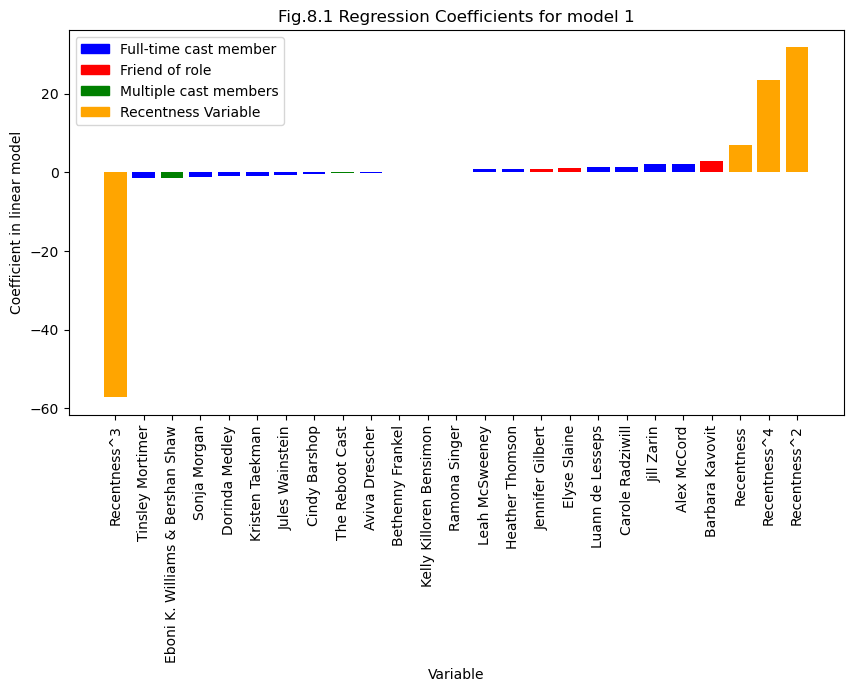

In [12]:
#Coefficient analysis

#Creating a dataframe of a dictionary of each of the coefficients 
variable_coefficients = pd.DataFrame({
    'Variable': X_cols.columns,
    'Coefficients': model.coef_.flatten()
})
#Ordering the coefficients, and plotting them as a bar chart
variable_coefficients = variable_coefficients.sort_values(by = 'Coefficients')

#Creating a list of cast members who have only been friends as a maximum role
friends_list = cast_list[23:]

#Plotting
plt.figure(figsize=(10,5))
for index, row in variable_coefficients.iterrows():
    if row['Variable'] in friends_list:
        colour = 'red'
    elif row['Variable'] in cast_list:
        colour = 'blue'
    elif row['Variable'] in ["The Reboot Cast","Eboni K. Williams & Bershan Shaw"]:
        colour = 'green'
    else: 
        colour = "orange"
    plt.bar(row['Variable'], row['Coefficients'], color=colour)
    
legend_handles = (mpatches.Patch(color='Blue', label='Full-time cast member'),
                  mpatches.Patch(color='Red', label='Friend of role'),
                  mpatches.Patch(color='Green', label='Multiple cast members'),
                  mpatches.Patch(color='Orange', label='Recentness Variable'))

plt.legend(handles = legend_handles)

plt.legend(handles = legend_handles)
plt.xticks(rotation =90)
plt.title("Fig.8.1 Regression Coefficients for model 1")
plt.xlabel('Variable')
plt.ylabel('Coefficient in linear model')
plt.show()

Figure 8.1 shows the value of the coefficient for each value in the linear model. Due to the standardisation of the recentness value, the recentness coefficients are quite high making this graph quite hard to interpret. A new plot is created to only show how much the cast members themselves contribute.

The reason the recentness scores are so high is because they are on a very different scale. Recentness has been scaled from 0 to 1, so the powers of the recentness values that are less than 1 to become incredibly small. In terms of the linear model capturing their contribution, a very high coefficient is required to scale them up to size. This also reflects the significance of the recentness.

Given the fact that the full-time cast members employment score is goes from 0 to 1, these coefficients have a nice interpretation. The value of each coefficient for each cast member corresponds to how many extra (or fewer) views they would be predicted to contribute if they were to appear in a given season (full-time).

These coefficients can be used to extrapolate how many views someone in a friend role would contribute to an episode if they were in a full-time role. To retain some sense of interpretability for what a friend already is predicted to contribute in a friend role, the coefficient would need to be multiplied by the friend score (0.5).

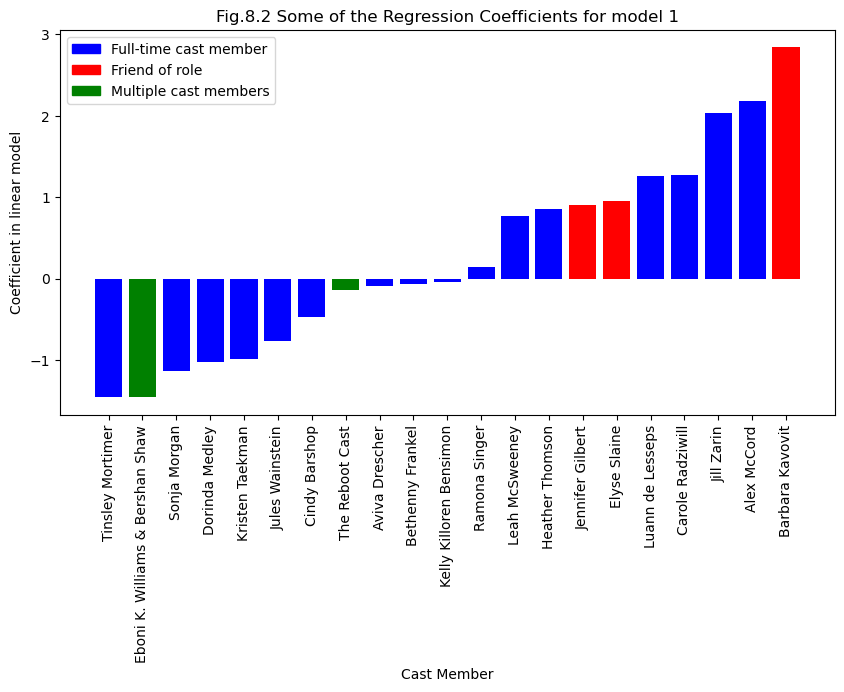

In [13]:
#Re-visualising the previous plot without the recentness variables, to put meaning on the coefficients for the cast

variable_coefficients_copy = variable_coefficients.copy()
variable_coefficients_copy = variable_coefficients_copy.sort_values(by = 'Coefficients')
#Dropping the columns with "recentness values"
variable_coefficients_copy = variable_coefficients_copy.drop(24)
variable_coefficients_copy = variable_coefficients_copy.drop(23)
variable_coefficients_copy = variable_coefficients_copy.drop(22)
variable_coefficients_copy = variable_coefficients_copy.drop(21)
        
        
variable_coefficients_copy = variable_coefficients_copy.sort_values(by = 'Coefficients')

plt.figure(figsize=(10,5))

for index, row in variable_coefficients_copy.iterrows():
    if row['Variable'] in friends_list:
        colour = 'red'
    elif row['Variable'] in cast_list:
        colour = 'blue'
    else:
        colour = 'green'
    plt.bar(row['Variable'], row['Coefficients'], color=colour)
    
legend_handles = (mpatches.Patch(color='Blue', label='Full-time cast member'),
                  mpatches.Patch(color='Red', label='Friend of role'),
                  mpatches.Patch(color='Green', label='Multiple cast members'))

plt.legend(handles = legend_handles)

plt.xticks(rotation =90)
plt.title("Fig.8.2 Some of the Regression Coefficients for model 1")
plt.xlabel('Cast Member')
plt.ylabel('Coefficient in linear model')
plt.show()



Figure 8.2 shows an adjustment of figure 8.1, without the recentness variables. This allows us to see how each cast member contributes in terms of viewers.

According to this diagram, the cast member that would contribute the most viewers to an episode (in a full-time role) is Barbara Kavovit. Even if this value is extrapolatory, Kavovit appearing in a friend role would be predicted to add approximately 1.5 million viewers. Kavovit only appeared in one season in a friend role (and a few as a guest) so there aren't a lot of episodes to back up a claim that Kavovit increases viewership. Alex McCord and Jill Zarin each appeared in 4 seasons as full-time cast members, and their scores are very high, indicating that they increase viewership. Whilst based on data from older seasons, this is likely true, as fans like seeing cast members from past seasons (which attracted more viewers). 

Is it feasible to say that would both Zarin and McCord contribute 2 million viewers each if they appeared full-time in a new season? Not really, however that is what my model implies, which may be considered a flaw. To remedy this, as an extension, it could be possible to compare the RHONY viewership data with viewership data of all TV series over time, this would likely introduce a harsher or lighter penalty on the recentness variable, giving a more accurate insight as to how much the casting decisions contribute to viewership.

Tinsley Mortimer and the combined Williams & Shaw variables had a negative effect on viewership. These are both likely because they were featured on more recent seasons, not because they drive away viewers. It is hard to predict how both Williams & Shaw would each contribute to viewership independently because there is little data that separates them. The only thing that could provide this insight is according to their employment scores, the problem is constructed such that Williams contributes to (1/1.5) or 2/3s and Shaw contributes 1/3 to their combined coefficient, which should be multiplied by 1.5 to indicate their total contribution to predicting viewership.

Frankel has a score near 0 which contradicts prior statements about her being associated with a large viewership.

Because model 1 has many variables, a second model is created. This one only takes into account the recentness and the powers of the recentness to see how they contribute to the model.

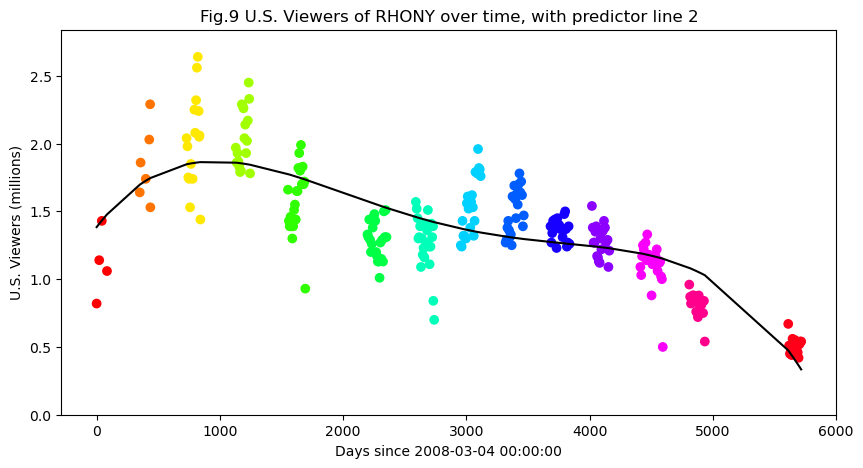

In [14]:
##Linear model method 2
#Copying into a second data set
rhony_episodes_lm_df_2 = rhony_episodes_lm_df.copy()

#Subsetting the column(s) of interest like before
X_col_titles_2 = ['Days since premiere']
X_cols_2 = rhony_episodes_lm_df_2[X_col_titles_2].copy()
X_cols_2['Days since premiere'] = X_cols_2['Days since premiere']/X_cols_2['Days since premiere'].max()
X_cols_2.rename(columns={'Days since premiere': 'Recentness'}, inplace=True)

#Manipulating recentness variable as before
X_cols_2['Recentness^2'] = np.power(X_cols_2['Recentness'], 2)
X_cols_2['Recentness^3'] = np.power(X_cols_2['Recentness'], 3)
X_cols_2['Recentness^4'] = np.power(X_cols_2['Recentness'], 4)

y_col_2 = rhony_episodes_lm_df_2[['U.S. viewers (millions)']].copy()

#Second linear model
model_2 = LinearRegression()

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_cols_2, y_col_2, test_size=0.2, random_state=0)

model_2.fit(X_train_2, y_train_2)

y_line_points_2 = model_2.predict(X_cols_2)
x_line_points_2 =  X_cols_2['Recentness'] * rhony_episodes_lm_df_2['Days since premiere'].max()

#Plotting the second linear model
plt.figure(figsize=(10, 5))
cmap = plt.get_cmap('hsv', 14)
plt.scatter(rhony_episodes_lm_df_2['Days since premiere'],rhony_episodes_lm_df_2['U.S. viewers (millions)'], c=rhony_episodes_df_2['Season'], cmap=cmap) 
plt.plot(x_line_points_2, y_line_points_2, color = "black")
plt.xlabel('Days since ' + str(start_date))
plt.ylabel('U.S. Viewers (millions)')
plt.title('Fig.9 U.S. Viewers of RHONY over time, with predictor line 2')
plt.ylim(0, max(rhony_episodes_df_2['U.S. viewers (millions)'])+0.2)
plt.show()


Figure 9 supports the prior statement about the viewership following a quartic curve. This figure captures the trend in the data well but doesn't overfit as much as model 1. The MSE of model 2 is calculated to evaluate how successful this model is on the test data.

In [15]:
y_hat_2 = model_2.predict(X_test_2)
mse_2 = mean_squared_error(y_hat_2,y_test_2)
print(f"The MSE for model 2 is ", round(mse_2,4))

The MSE for model 2 is  0.0787


This is a low MSE too, however it is greater than the MSE of model 1. This indicates that this model is worse at predicting viewership. Perhaps this is because too few variables were used. This model is much less likely to suffer from overfitting or collinearity between variables. Both models incorporate a quartic function on recentness. Due to the nature of polynomials (rapid growth) both models would perform poorly to extrapolate data on future season.

As an extension it could be possible to consider recentness being a sinusoidal function, implying that viewership fluctuates over time.

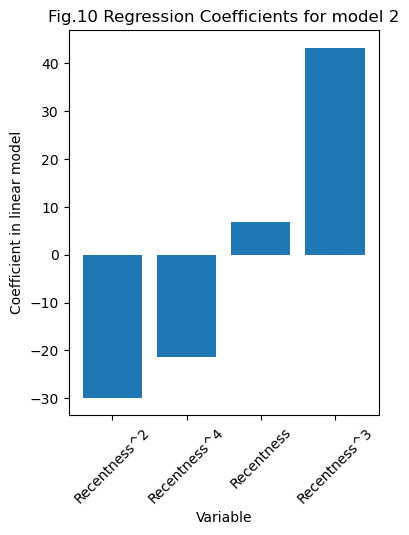

In [16]:
#Coefficient analysis part 2

#All as before
variable_coefficients_2 = pd.DataFrame({
    'Variable': X_cols_2.columns,
    'Coefficients': model_2.coef_.flatten()
})

variable_coefficients_2 = variable_coefficients_2.sort_values(by = 'Coefficients')

#Plot
plt.figure(figsize=(4,5))
plt.bar(variable_coefficients_2['Variable'], variable_coefficients_2['Coefficients'])
plt.xticks(rotation =45)
plt.title("Fig.10 Regression Coefficients for model 2")
plt.xlabel('Variable')
plt.ylabel('Coefficient in linear model')

plt.show()

Figure 10 is similar to figures 8.1 and 8.2, this figure is much easier to read. This shows the coefficients for the recentness score. Because recentness has been standardised, and a function has been applied, this loses interpretability.

To see if the viewership over time can really be modelled by a quadratic curve, it is possible to do a hypothesis test, however first it is necessary to import a new library to create a linear model in a new fashion. The statsmodel.api library can be used to do this (the mathematical justification is loosely described) by taking the regression problem as the optimisation of an OLS (ordinary least squares) problem in $\beta$ in $y=\beta X$ where y is the response variable and X is the predictor matrix with a constant term applied, according to the definition of a linear model.

The information about this package can be found: https://www.statsmodels.org/stable/user-guide.html#user-guide

The reason for importing this package is due to its ease in computing p values for a regression model, testing the hypothesis whether each coefficient contributes to the model significantly.

The hypotheses are outlined as follows, where j is an index and $\beta_j$ refers to the $j^{th}$ column in $\beta$, or the $j^{th}$ coefficient.

for every j (0-3):
    $$H_0 : \beta_j = 0$$
    $$H_1 : \beta_j \neq 0$$.

In [17]:
#Hypothesis testing of model 1

#Importing a statistical library
import statsmodels.api as sm
#Adding a constant term in my predictor variable matrix
X_train_2 = sm.add_constant(X_train_2)
#Fitting a linear model using a second technique
model_2_alt = sm.OLS(y_train_2,X_train_2).fit()
#Printing the p values for my regression coefficients
print(f"The p-values for model 2 are: \n", model_2_alt.pvalues)
print(f"\nThe coefficients for model 2 are: \n", model_2_alt.params)

The p-values for model 2 are: 
 const           1.925682e-27
Recentness      2.469974e-07
Recentness^2    1.598406e-09
Recentness^3    8.870105e-10
Recentness^4    3.246174e-10
dtype: float64

The coefficients for model 2 are: 
 const            1.383978
Recentness       6.779979
Recentness^2   -29.849775
Recentness^3    43.288790
Recentness^4   -21.268666
dtype: float64


The fact that the coefficient values correspond to those in figure 10 shows that this method of creating a linear model is identical to the one created using sklearn.

The p-values are drawn according to a t test and support the alternative hypothesis for each column as they are all incredibly small. Hence it is fair to say that there is evidence to suggest that U.S. viewership can be modelled as a (quartic) polynomial function of time.

It could be possible to extend the linear model by using a generalised linear model (where the response variable is modelled as a function of $\beta$ * predictor matrix, and the data doesn't need to follow a normal distribution) to give more accurate and deeper levels of insight. This is outlined as an extension.

## Question 3

To answer question 3, basic Natural Language Processing (NLP) techniques are used. The corpus (the set of every title of each RHONY episode) is found to be quite short, however it is possible to visualise some of the trends seen.

To do this, certain words in the corpus are standardised and counted. The words that are standardised are due to their interest, and the three categories of words of interest are:

1. Words about New York City. "NY" and "New York" both appear in the context of referring to geographical location. The word processing splits title by word, so any "New York" is considered one word - "newyork" so that it is counted as one. Then "NY" is standardised so that it grouped with other references to New York. "Apple(s)" is also considered a reference to New York (as New York is referred to the "Big Apple", something which the show plays on frequently).

2. Names of cast members. There is already a cast list of every cast member, so it is possible to see if words in the title are in this set. This set needs splitting because the mention of the first or surname of a cast member should count as a reference to them. Titles with wordplay are separated so that names are still counted (for example, "Brynnteresting" is separated to "Brynn Interesting"). "Countess" is often used to refer to Luann De Lesseps (as that is her official title and is used in her stage-name) so that word is included in this category. Fortunately, there aren't many cast members whose names are shared with either other nouns in the corpus, or each other. For example, an episode's title including the word "Singer" to refer to someone singing would be falsely counted as a reference to Ramona Singer. Luckily there is no such title. Both Sai De Silva and Luann De Lesseps share "De" in their surnames, luckily this does not appear in any title so there is no confusion about assignment. This code does not account for pre-marital names being included in episode titles. This is a non-issue as far as is known, however this could be considered an extension. Finally, there is one episode in which "B" is used to refer to Bethenny Frankel, so that is codified, however it is important to be careful that every "B" is not replaced by "Bethenny" so, every "B " (with a space) is replaced, except in the title that includes the word "Mob ".

3. Nouns referring to women, girls, or wives. These values are simpler and are mostly just depluralised. This category is split into two, words which represent women, and words which represent women in a marital context. This is to gain insight to how RHONY's presentation of women has changed. "Countess" is not included in this list since it refers to the nickname of De Lesseps more than a referral to women. An offensive word that can be used to refer to women is not included in this category for ethical reasons, even if it does appear in titles.

There is not a one function fits all method to cleaning these words (even depluralising an object is challenging) so it has to be done manually, with a dictionary mapping words that need to be replaced.

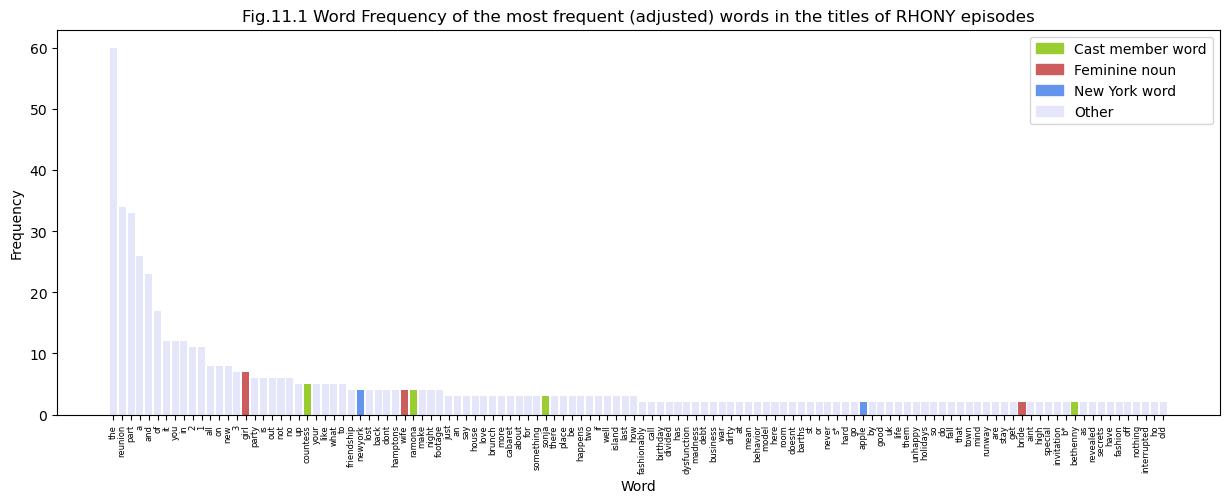

In [18]:
#Empty dictionary to count frequency of words that appear
word_count = {}

#A string of all punctuation characters that occur/may occur in the titles
punctuation = '''!,.\"—('):;?'''
#A collection of nouns of interest to allow for analysis later
singular_feminine_nouns = ["girl",'wife','housewife',"woman","bride","gal"]
#Creating a new df
rhony_episodes_df_nlp = rhony_episodes_df.copy()

#A function that takes the punctuation out of a word
def depunctuate(word):
    for character in word:
            if character in punctuation:
                word = word.replace(character,"")
    return(word)

#A dictionary of words, parts of words I want to replace, mostly plurals
alterations = {
        " ny ": " newyork ", # Gathering new york mentions
        "new york": "newyork",
        "b " : "bethenny ", #There is a title where 'B' is short for bethenny
        "girls" : "girl", #Plural
        "'s": "", #Removing 's as a contraction or possession so girl's and girl are counted the same 
        "housewives": "housewife",
        "wives": "wife",
        "women": "woman",
        "brynnteresting": "brynn teresting", #Separating plays on words so I can count the name 
        "ramoaning": "ramona moaning",
        "ramona'd": "ramona ed",
        "galentine": "gal valentine",
        "apples": "apple",
        "...": "*" #Offensive words are sometimes censored in the original dataset with "..." so I am standardising them
    }
#Iterating over every episode
for index in range(len(rhony_episodes_df_nlp)):
    #Adjusting the titles so they are lowercase strings
    rhony_episodes_df_nlp.loc[index, "Title"] = str(rhony_episodes_df_nlp.loc[index, "Title"])
    rhony_episodes_df_nlp.loc[index, "Title"] = rhony_episodes_df_nlp.loc[index, "Title"].lower()
    
    #Giving the name of each corrected episode
    for i in alterations:
        if i in rhony_episodes_df_nlp.loc[index, "Title"] and not "mob " in rhony_episodes_df_nlp.loc[index, "Title"]:
            
            #Code to print every changed title is hashtagged in 2 parts
            #print(f"The title: ", rhony_episodes_df_nlp.loc[index, "Title"])
            rhony_episodes_df_nlp.loc[index, "Title"] =  rhony_episodes_df_nlp.loc[index, "Title"].replace(i,alterations[i])
            #print(f" is now: ", rhony_episodes_df_nlp.loc[index, "Title"])
            
    rhony_episodes_df_nlp.loc[index, "Title"] = depunctuate(rhony_episodes_df_nlp.loc[index, "Title"])
            
    #Iterating over every word in the title of the episode 
    for word in rhony_episodes_df_nlp.loc[index, "Title"].split():
        word = str(word)
        word = depunctuate(word) 
        if word in word_count:
            word_count[word]+=1 #Adding one to the count of the existing count
        else:
            word_count[word] = 1 #Creating a new count

#Coverting to a dataframe and sorting
word_count = pd.DataFrame(list(word_count.items()), columns=["Word", "Count"])
word_count = word_count.sort_values(by = "Count",ascending = False)
#Removing empty values
word_count = word_count[word_count['Word'] != ""]

#A second CSV file is created showing the frequencies of words in the title.
word_count.to_csv('word_count.csv', index=False)

#Creating a list of names of interest
cast_names = []
for cast_member in cast_list:
    cast_member = cast_member.lower()
    for name in cast_member.split():
        if len(name) > 2:
            cast_names.append(name)
cast_names.append("countess") #Luann DeLesseps' official title is Countess



plt.figure(figsize=(15,5))

for index, row in word_count.iterrows():
    if row['Count'] > 1:
        if row['Word'] in cast_names:
            colour = 'yellowgreen'
        elif row['Word'] in singular_feminine_nouns:
            colour = 'indianred'
        elif row["Word"] == "newyork" or row["Word"] == "apple":
            colour = 'cornflowerblue'
        else:
            colour = "lavender"
        plt.bar(row['Word'], row['Count'], color=colour)
    
legend_handles = (mpatches.Patch(color='yellowgreen', label='Cast member word'),
                  mpatches.Patch(color='indianred', label='Feminine noun'),
                  mpatches.Patch(color='cornflowerblue', label='New York word'),
                  mpatches.Patch(color='lavender', label='Other'))

plt.legend(handles = legend_handles)
plt.xticks(rotation =90, fontsize = 6)
plt.title('Fig.11.1 Word Frequency of the most frequent (adjusted) words in the titles of RHONY episodes')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

Figure 11.1 shows the frequency of the most frequent words in the corpus (words with frequency greater than 1). There are many words which are common words that are of no interest - for example "the" being the most frequent word. This graph is hard to interpret because there are too many insignificant words plotted. To remedy this, a second plot is generated, only plotting words of interest.

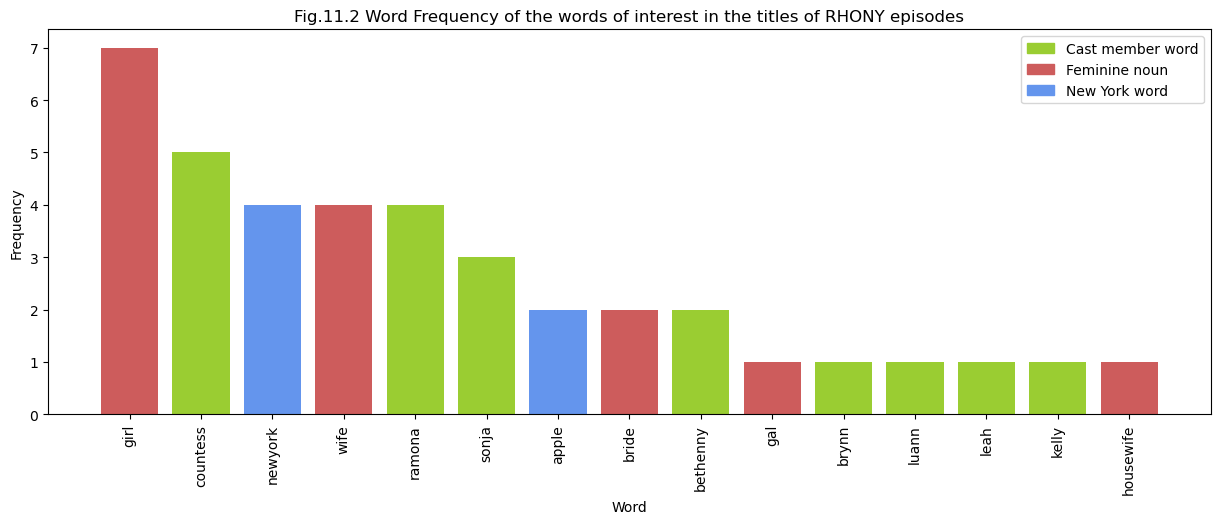

In [19]:
#Second word frequency bar graph

#Only plotting the words of interest in this graph
for word in word_count['Word']:
    if word == "newyork" or word == "apple":
        pass
    elif word in cast_names:
        pass
    elif word in singular_feminine_nouns:
        pass
    else:
        word_count = word_count.drop(word_count[word_count['Word'] == word].index)
    

plt.figure(figsize=(15,5))

for index, row in word_count.iterrows():
    if row['Word'] in cast_names:
        colour = 'yellowgreen'
    elif row['Word'] in singular_feminine_nouns:
        colour = 'indianred'
    elif row["Word"] == "newyork" or row["Word"] == "apple":
        colour = 'cornflowerblue'
    else:
        colour = "lavender"
    plt.bar(row['Word'], row['Count'], color=colour)
    
legend_handles = (mpatches.Patch(color='yellowgreen', label='Cast member word'),
                  mpatches.Patch(color='indianred', label='Feminine noun'),
                  mpatches.Patch(color='cornflowerblue', label='New York word'))


plt.xticks(rotation =90, fontsize = 10)
plt.legend(handles = legend_handles)
plt.title('Fig.11.2 Word Frequency of the words of interest in the titles of RHONY episodes')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

Figure 11.2 is much more interpretable and it is possible to see which words (of interest) are most frequent. It is possible to see that "girl" is the most frequent word of those selected, indicating how the cast members are frequently referred to as "girls". It is also possible to see that (Countess) Luann De Lesseps is the member most referred to in episode titles, due to the high counts of the word "Countess". This reflects the iconic-ness of the title/nickname. It also seems that words associated with New York are referred to multiple times, indicating the importance of the state/city within the show.

The following cell involves data processing and includes a measure of if words of interest are included in titles for each episode, 1 meaning "Yes" 0 meaning "No" for each category.

In [20]:
#Highlighting episodes with specific mentions, on figure 1

#This cell can only be ran once without having to reset the kernel

#Creating a counter variable for each category that could be mentioned 
rhony_episodes_df_nlp["NY mention"]= 0
rhony_episodes_df_nlp["Cast member mention"]= 0
rhony_episodes_df_nlp["Fem noun mention"] = 0

#Changing the value from 0 to 1 if a specific category of word is mentioned
#This value 
for index in range(len(rhony_episodes_df_nlp)):
    word_string = str(rhony_episodes_df_nlp.loc[index, "Title"]).split()
    for word in word_string:
        word = depunctuate(word)
        if word in cast_names:
            rhony_episodes_df_nlp.loc[index, "Cast member mention"] = 1
        if word in singular_feminine_nouns:
            rhony_episodes_df_nlp.loc[index, "Fem noun mention"] = 1
            #Here its a little complicated, less consistent and less generalisable from a word mention indicator to RGB scores
            if word in ["wife","housewife","bride"]:
                if rhony_episodes_df_nlp.loc[index, "Cast member mention"] != 1:
                    rhony_episodes_df_nlp.loc[index, "Cast member mention"] = 0.75
                    rhony_episodes_df_nlp.loc[index, "NY mention"] = 0.75
                    #If this is the case, the colour should be pink
                else:
                    rhony_episodes_df_nlp.loc[index, "Cast member mention"] = 0.7
                    #If this is the case, the colour should be orange
        if word in ["newyork","apple"]:
            rhony_episodes_df_nlp.loc[index, "NY mention"] = 1

#Adjusting data ready to plot

rhony_episodes_df_nlp = rhony_episodes_df_nlp.dropna(subset=['U.S. viewers (millions)']).copy()
#Unfortunately some titles of interest are lost here which is unfortunate
#This decision is justified for consistency in the scatter plots
rhony_episodes_df_nlp['U.S. viewers (millions)'] = rhony_episodes_df_nlp['U.S. viewers (millions)'].str.replace(r'\[.*\]', '', regex=True)
rhony_episodes_df_nlp['U.S. viewers (millions)'] = rhony_episodes_df_nlp['U.S. viewers (millions)'].astype(float)

The indicator of whether an episode title contains a word of interest corresponds to RGB values. To visualise the subset of episodes which have a marital noun that refers to women, the RGB values need adjusting. If there is a marital noun used then the colour becomes lighter, something which has to be inputted manually to retain visibility (as a lighter value for (1,1,0) would be very hard to see) hence a light orange colour was chosen to indicate a lighter value that encoportates R > 0 and G > 0. This loses some of the interpretability of the RGB scores corresponding to categories of words being in a title, however visualising the data is more important.

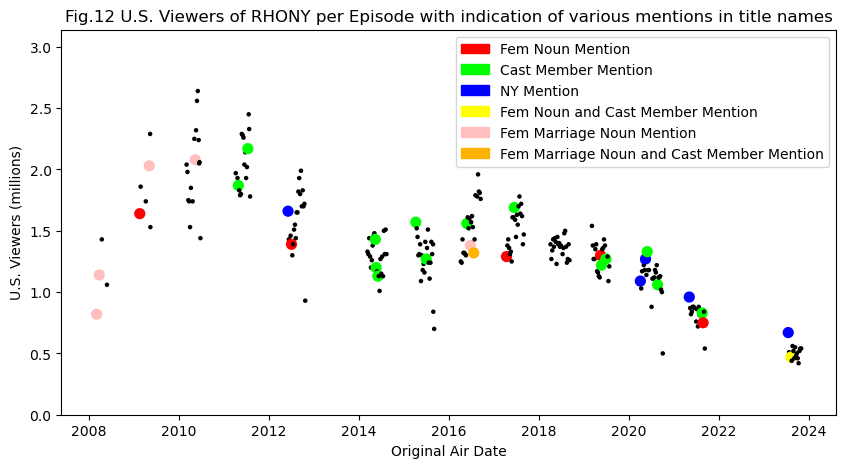

In [21]:
#The plotting of the episodes based on whether or not they contain words of interest 
legends = [
    mpatches.Patch(color=[1, 0, 0], label='Fem Noun Mention'), #R
    mpatches.Patch(color=[0, 1, 0], label='Cast Member Mention'),#G
    mpatches.Patch(color=[0, 0, 1], label='NY Mention'),#B
    mpatches.Patch(color=[1, 1, 0], label='Fem Noun and Cast Member Mention'),#RG (yellow)
    mpatches.Patch(color=[1, 0.75, 0.75], label='Fem Marriage Noun Mention'),#R (lighter) (pink)
    mpatches.Patch(color=[1, 0.7, 0], label='Fem Marriage Noun and Cast Member Mention') #RG (lighter) (orange)
]

colours = rhony_episodes_df_nlp[['Fem noun mention', 'Cast member mention','NY mention']].values

#This is to make the point size of words of non-interest smaller
point_size = [10]*len(rhony_episodes_df_nlp)
for index, colour in enumerate(colours):
    if (np.array(colour) == [0,0,0]).all():
        point_size[index] = 5
    else:
        point_size[index] = 50

plt.figure(figsize=(10, 5))

plt.scatter(rhony_episodes_df_2['Original air date'],rhony_episodes_df_2['U.S. viewers (millions)'],color = colours, s = point_size) 
plt.legend(handles=legends)
plt.xlabel('Original Air Date')
plt.ylabel('U.S. Viewers (millions)')
plt.title('Fig.12 U.S. Viewers of RHONY per Episode with indication of various mentions in title names')
plt.ylim(0, max(rhony_episodes_df_2['U.S. viewers (millions)'])+0.5)

plt.show()

Figure 12 shows how each of the words of interest change over time, and how they might impact viewership. Cast members seem to be referred to consistently throughout the show. 

New York seems to be referred to more in the more recent episodes of the show and is associated (at least in 2020 2021 and 2023) with more viewed episodes. It is possible that in these covid and post-covid years, viewers are attracted to watch episodes containing titles about New York, as travel had been restricted, meaning viewers longed for a sense of travel and referencing New York gives a stronger sense of place. It is also possibly explained by the fact that the season premieres of Seasons 13 and 14 refer to New York, and premiere episodes could draw in more viewers. Further investigation into this hypothesis could be done as an extension.

It is apparent that feminine nouns that refer to marriage (pink and orange points) are less frequent in more recent seasons, and other feminine nouns are fairly evenly spread. The fact that marital nouns are used less in reference to the cast members reflect a changing perception of women presented by the show. 

The implication of how different nouns refer to women is a complex topic which involves a high level of depth which is beyond the scope of this project. Some short analysis is given, however. The use of words like "wives" and "housewives" imply that it is important to refer to the women as married, in a way the definition of a woman is dependent on the fact that she has a husband($*$). As time has gone on there have been more and more cast members hired who are not married and so their contribution was not through their marital status or husband hence the cast members were referred to as "wives" or "housewives" in titles less frequently. It is possible to conclude that RHONY as a show has progressed to present women independently from their marital status - as "women" (or "girls"), rather than "housewives". 

This comment made is ironic as the franchise has been consistently called "The Real Housewives" however one could argue that this has become more of a brand name, and that "Real Housewife" as a term has more depth beyond first impression.

These are claims/analyses that begin to scratch the surface of this topic and it would be possible to collect more data in an extension (perhaps doing NLP on episode descriptions or wider research on how women are presented in the show, or even the "Real Housewives" franchise, perhaps including a cast members marital status over time, which is available on Wikipedia).

($*$)(There are no cast members featured who are married to women)

The following cell is used to see the context of feminine nouns over time, giving episode titles and their release date.

In [22]:
rhony_episodes_df_nlp = rhony_episodes_df_nlp.reset_index(drop=True)
for index in range(len(rhony_episodes_df_nlp)):
    if rhony_episodes_df_nlp.loc[index, 'Fem noun mention'] > 0:
        print(f"",str(rhony_episodes_df_nlp.loc[index, "Title"])," -  was released on ", 
              str(rhony_episodes_df_nlp.loc[index, "Original air date"].strftime('%d/%m/%Y')))

 meet the wife  -  was released on  04/03/2008
 social wife  -  was released on  25/03/2008
 there a new girl in town  -  was released on  17/02/2009
 charity wife  -  was released on  05/05/2009
 housewife overboard  -  was released on  13/05/2010
 the cool girl  -  was released on  02/07/2012
 always the b* never the bride  -  was released on  22/06/2016
 the countess bride  -  was released on  20/07/2016
 it girl interrupted  -  was released on  12/04/2017
 upstate girl  -  was released on  15/05/2019
 be mine gal valentine  -  was released on  24/08/2021
 the most brynn teresting girl in the room  -  was released on  06/08/2023


This shows how the only referal to women as by marital nouns after 2010 was in 2016, where a large storyline was Luann De Lesseps' marriage. This has different implications than referring to each of the women as "Housewives", but more so refers to De Lesseps's specific marriage journey. It is important to note that a woman being married or being a wife/bride does not imply that their contribution to something (for example RHONY) is dependent on their spouse (in the case of RHONY this being a man). More so "wives" and "housewives" being used as blanket statements for the women in a way that has implications as outlined previously.

Many improvements/extensions have been outlined through this project; however more are outlined.

It could be possible to extend the data to analyse how trends and conclusions extend to the episodes of spinoff shows, for example "Real Housewives Ultimate Girls trip" (RHUGT) (a cast of Real Housewives from various franchises go on holiday for approximately 6 episodes) for which every season contains at least one cast member from RHONY. Season 4 of RHUGT is noteworthy as this season contains exclusively cast members from RHONY. This could give more insight to how the cast from RHONY contribute viewership to episodes. As a further extension the set of all Real Housewives cities could be considered to give an even better analysis to how women are presented as Real Housewives. To gain more insight about episodes and viewer responses, an API tool could be used to scrape data from fan posts about the show, to measure sentiment analysis.

One could also consider including interaction terms in the model, to see if viewers respond well to seeing specific cast members together. It may be an exercise to try to create a clustering algorithm to see if it possible to predict the season number (or other attributes, for example reunion episodes) based on the data about the episodes. It could also be possible to include other variables about cast members or episodes (whether a cast member is married, whether an episode involves the women going on holiday etc).

There are many more additions that could be made however the list is quite extensive.

All data is sourced from (as of January 2024):

https://en.wikipedia.org/wiki/The_Real_Housewives_of_New_York_City
https://en.wikipedia.org/wiki/List_of_The_Real_Housewives_of_New_York_City_episodes#

Thank you for reading my project, I hope it proved interesting.
